#### Задание 

Провести анализ с помощью SSA любом из временных рядов с первого занятия. 

Посмотрите на результаты с разными длинами окон. 

Визуализируйте результаты

In [11]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [3]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [4]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [7]:
################
# Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', start_point=0, step=0):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

#        y.plot(ax=ts_ax, color='blue', label='Or')
        plot_ts_and_points(y, start_point, step, ts_ax)
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [16]:
def plot_ts_and_points(ts, start_point, step, ts_ax):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
#        plt.figure(figsize=(14, 8))
#        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')
        new_series.plot(ax=ts_ax, style='ro')

In [5]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [6]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

In [9]:
# загрузим данные
series_1 = all_series["Monthly sales of company X"]

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


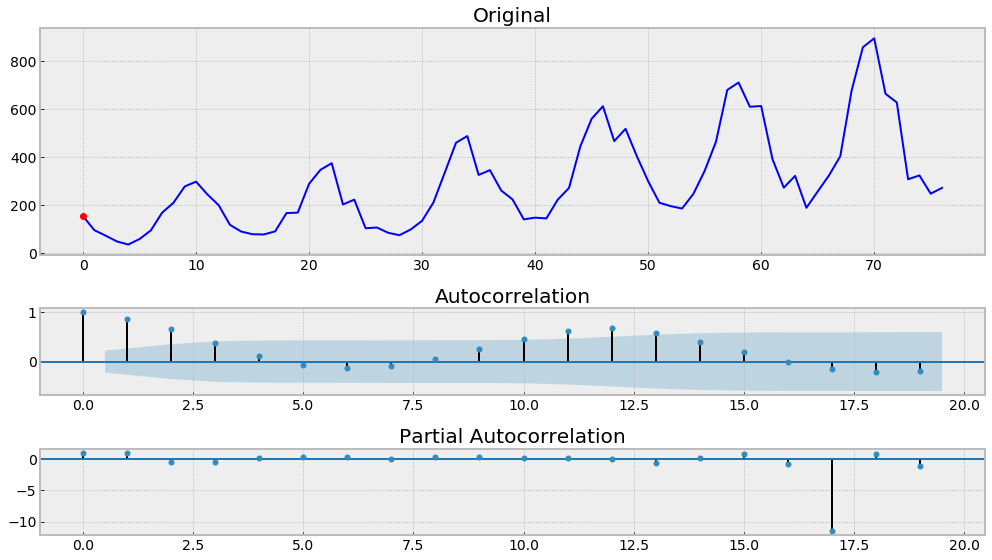

In [18]:
tsplot(series_1)

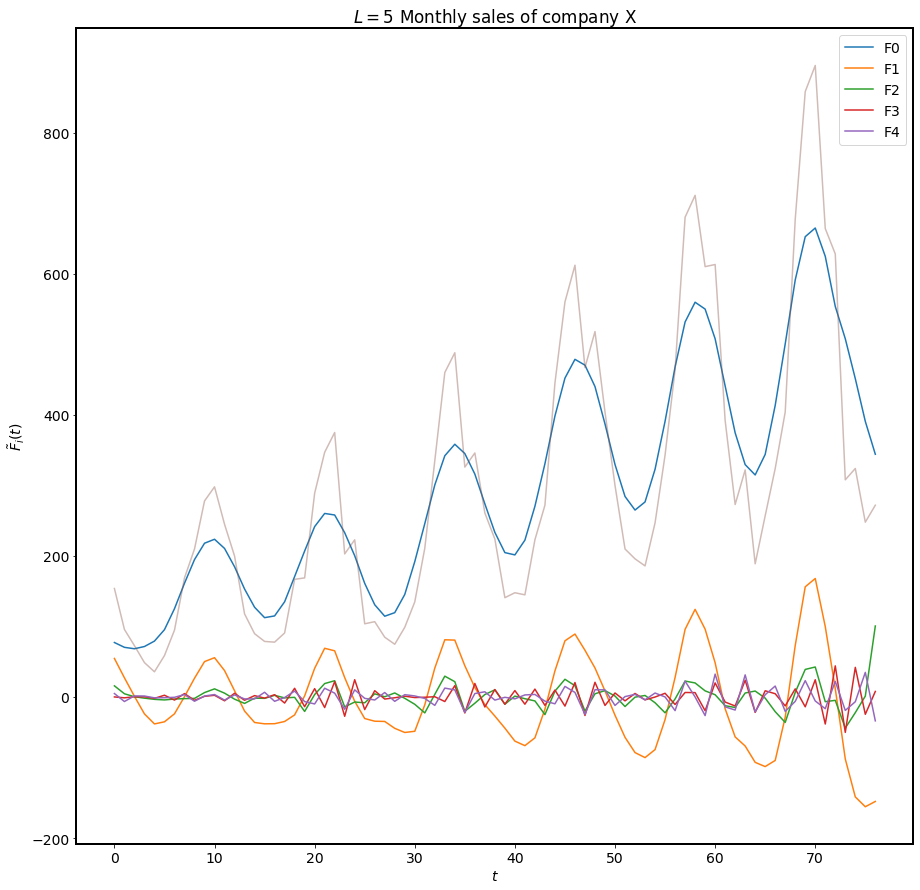

In [86]:
# установим длину окна 5 и применим SSA:
companyX_ssa_L5 = SSA(series_1, 5)
companyX_ssa_L5.components_to_df().plot()
companyX_ssa_L5.orig_TS.plot(alpha=0.4)
plt.rcParams['figure.figsize'] = (15,15)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ Monthly sales of company X");
plt.show()

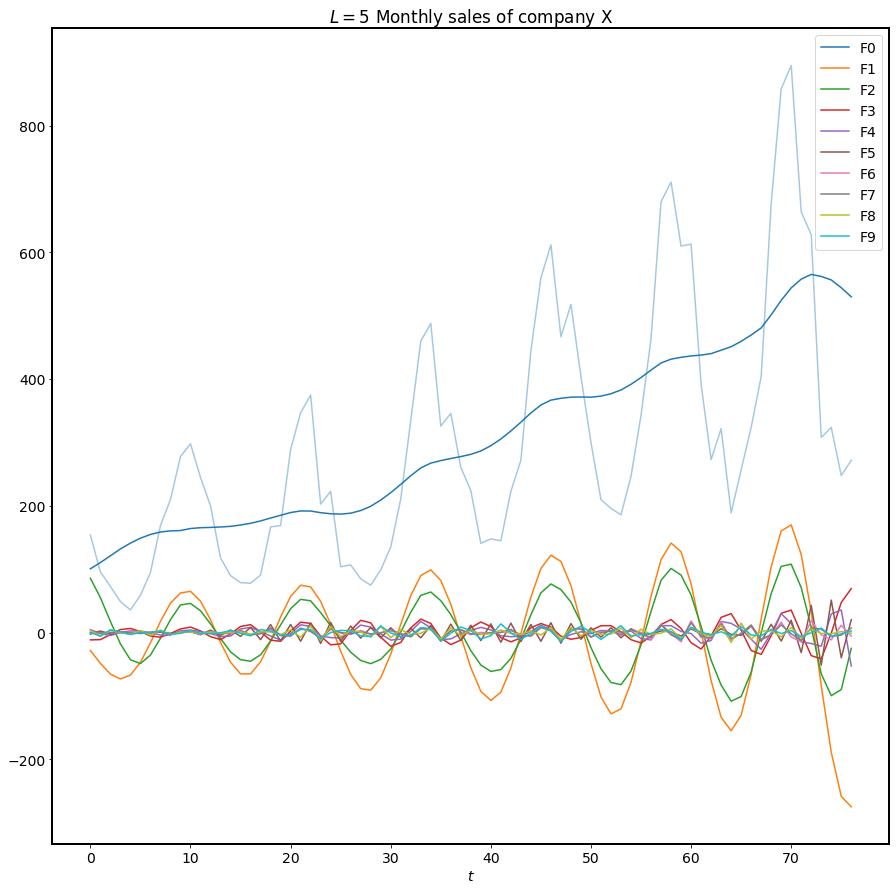

In [84]:
# установим длину окна 10 и применим SSA:
companyX_ssa_L10 = SSA(series_1, 10)
companyX_ssa_L10.components_to_df().plot()
companyX_ssa_L10.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
#plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ Monthly sales of company X");
plt.show()

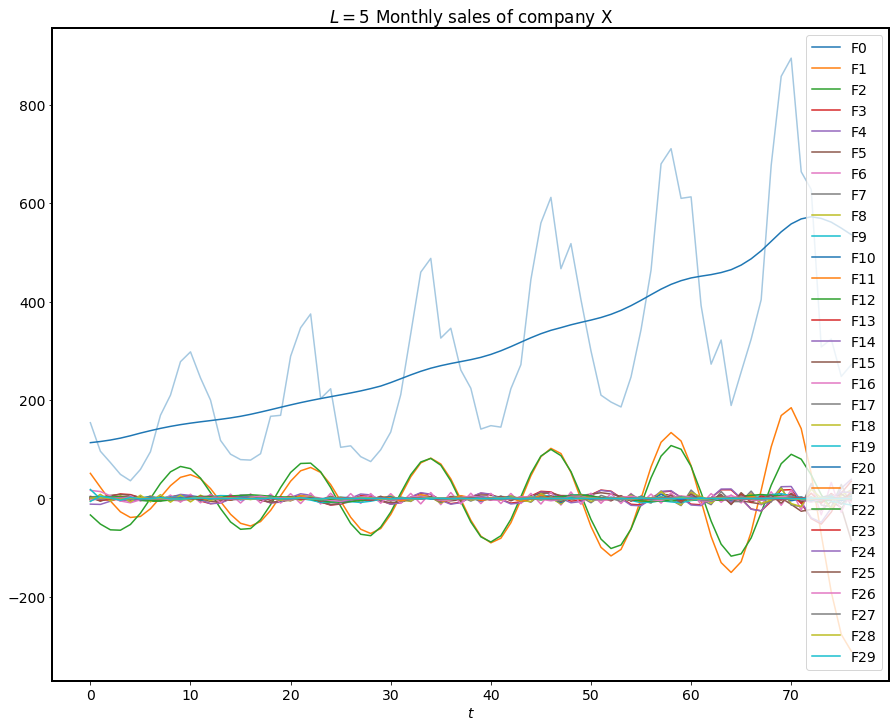

In [83]:
# установим длину окна 30 и применим SSA:
companyX_ssa_L30 = SSA(series_1, 30)
companyX_ssa_L30.components_to_df().plot()
companyX_ssa_L30.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
#plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ Monthly sales of company X")
plt.show()

In [87]:
# установим длину окна 15 и применим SSA:
start = 0 
end = len(series_1)
window = 15
companyX_ssa = SSA(series_1.loc[start:end], window)

Text(0.5, 1.0, 'Monthly sales of company X')

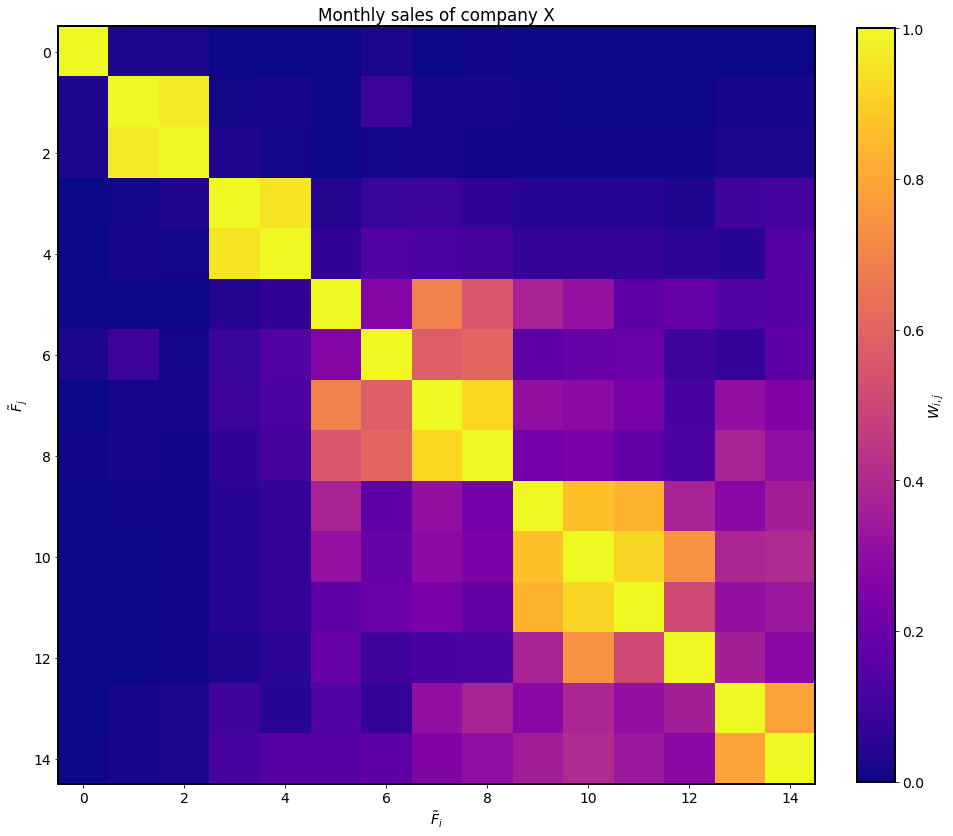

In [88]:
# построим матрицу w-корреляции
companyX_ssa.plot_wcorr()
plt.title("Monthly sales of company X")

(-15, 15)

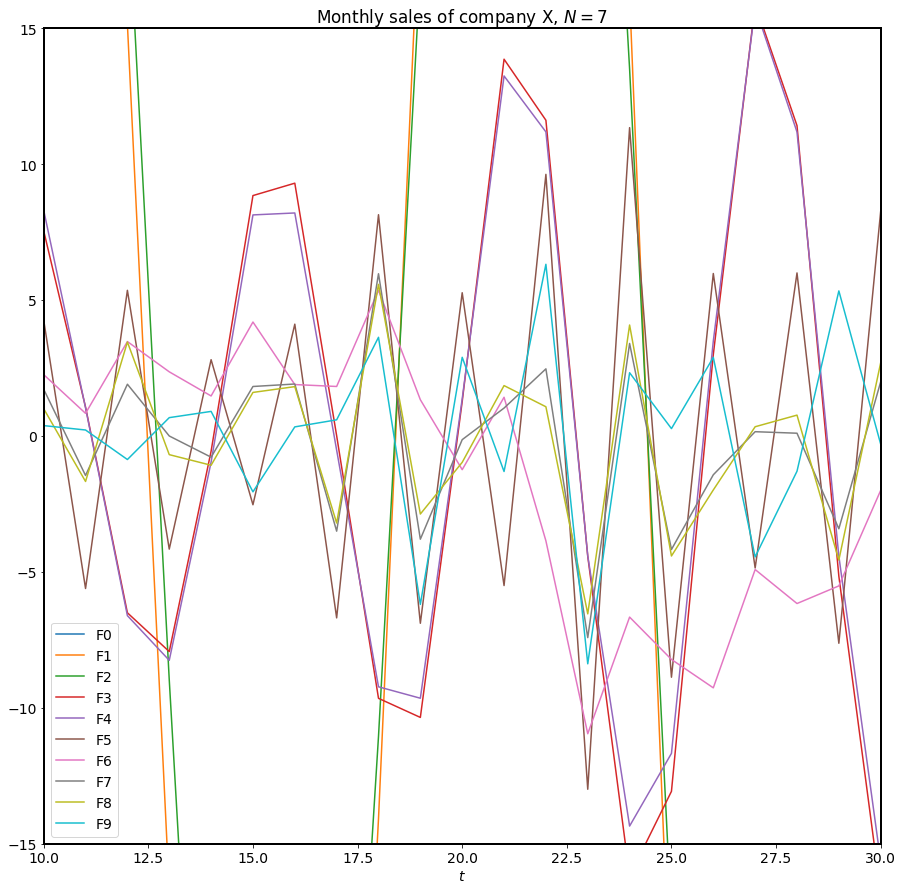

In [89]:
companyX_ssa.components_to_df(n=10).plot()
companyX_ssa.orig_TS.plot(alpha=0.4)  # Original
plt.title(r"Monthly sales of company X, $N=7$")
plt.xlabel(r"$t$");
plt.xlim(10,30)
plt.ylim(-15, 15)

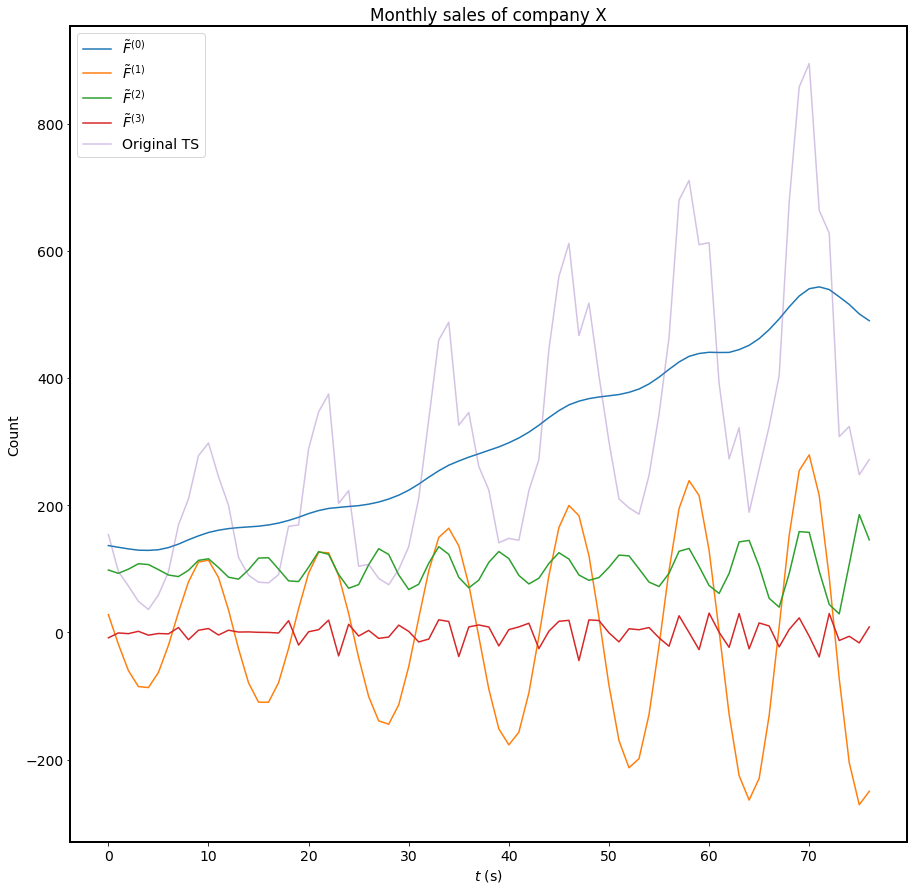

In [90]:
#5-7,8 / 6-7,8 / 7-8 / 9-10,11 / 10-11,12 /
companyX_ssa.reconstruct(0).plot() # F0
companyX_ssa.reconstruct([1,2]).plot() # F1
(companyX_ssa.reconstruct([3,4]) + 100).plot() # F2 Note: adding 100 to the series is for visualisation purposes only!
(companyX_ssa.reconstruct(slice(7,12))).plot() # F3
#(accel_ssa.reconstruct(slice(13,15))).plot() # F5
companyX_ssa.orig_TS.plot(alpha=0.4)  # Original
plt.title("Monthly sales of company X")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Count")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)] + ["Original TS"]
plt.legend(legend);
#plt.xlim(25,40)
#plt.ylim(-30, 30)

In [ ]:
# значимыми составляющими являются F0 - тренд, F1, F2 - периодичность, остальное шум